# Estimation on real data using MSM

In [1]:
from consav import runtools
runtools.write_numba_config(disable=0,threads=4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Local modules
from Model import RetirementClass
import figs
import SimulatedMinimumDistance as SMD

# Global modules
import numpy as np
import matplotlib.pyplot as plt

# Singles - Calibration to data in Jørgensen 2014

In [2]:
shape = (2,11)
moments = pd.read_excel('SASdata/Thomas/single_moments.xlsx')
mom_data = moments['Mom_data'].to_numpy()
mom_pred = moments['Mom_est'].to_numpy()
weight = np.eye(mom_data.size) # identity matrix

### Set up estimation

In [3]:
Single = RetirementClass(Thomas=True, simN=int(1e5), simT=68-57+1, alpha_1=0.053)
Single.solve()
Single.simulate()

In [4]:
# function to generate moments
def mom_fun(Single):
    return SMD.MomFunSingleThomas(Single)

In [5]:
est_par = ("alpha_0_male", "alpha_0_female", "sigma_eta")
smd = SMD.SimulatedMinimumDistance(Single,mom_data,mom_fun)
smd.est_par = est_par

### Estimate

In [6]:
theta0 = SMD.start(5,bounds=[(0.0,1.0), (0.0,1.0), (0.1,1.0)])

In [7]:
smd.MultiStart(theta0,weight)
theta = smd.est

1 estimation:
success: True | feval: 102 | time: 1.4 min | obj: 0.02446459025551699
start par: [0.132, 0.474, 0.792]
par:       [0.43316464 0.41115069 0.95724749]

2 estimation:
success: True | feval: 122 | time: 1.5 min | obj: 0.0244604093948479
start par: [0.513, 0.453, 0.593]
par:       [0.43280319 0.41146927 0.95586158]

3 estimation:
success: True | feval: 77 | time: 1.0 min | obj: 0.024522153929246913
start par: [0.849, 0.472, 0.613]
par:       [0.42089228 0.39711247 0.91175971]

4 estimation:
success: True | feval: 135 | time: 1.7 min | obj: 0.024465870934845334
start par: [0.539, 0.819, 0.486]
par:       [0.43561097 0.41482374 0.96686062]

5 estimation:
success: True | feval: 123 | time: 1.5 min | obj: 0.024455348591638563
start par: [0.544, 0.882, 0.766]
par:       [0.43444595 0.41323438 0.96235395]

final estimation:
success: True | feval: 78 | obj: 0.02434896047716067
total estimation time: 0.2 hours
start par: [0.43444595 0.41323438 0.96235395]
par: [0.42729572 0.41214954 0

In [8]:
Nobs = 27412 # equal to number of men-households (which is lower than women)
smd.std_error(theta,weight,Nobs=Nobs,Nsim=(5e5/2)/Nobs) # Nsim was set to 5e5 in MultiStart 
std_error = smd.std
smd.obj_fun(theta,weight) # set theta as parameters
print('Parameters:', np.round(theta,3))
print('Std error :', np.round(std_error,4))
est_par = list(est_par)
est_par.append("alpha_1")
theta = list(theta)
theta.append(Single.par.alpha_1)
SMD.save_est(est_par,theta,name='SingleThomas') # save parameters

Parameters: [0.427 0.412 0.965]
Std error : [0.0004 0.0001 0.0009]


### Model fit

In [9]:
def model_fit(ma,Single,mom_data,mom_pred,shape):
    mom_data = {'y': [mom_data.reshape(shape)[ma]], 'x': np.arange(58,69), 'label': ['Data'], 'color': 'k',
                'linestyle': ['None'], 'marker': 'o'}
    mom_pred = {'y': [mom_pred.reshape(shape)[ma]], 'x': np.arange(58,69), 'label': ['Jørgensen2014'], 'color': 'b',
                'linestyle': ['--']}    
    pred = figs.retirement_probs(Single,MA=[ma])
    pred['legendsize'] = 15
    return [mom_data, mom_pred, pred]

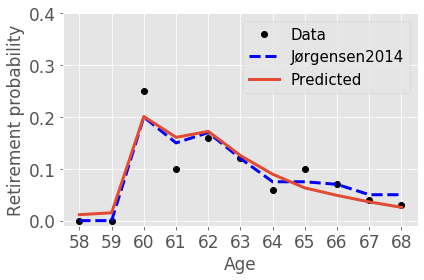

In [10]:
figs.MyPlot(model_fit(0,Single,mom_data,mom_pred,shape),
            ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/ThomasSingleWomen.png')

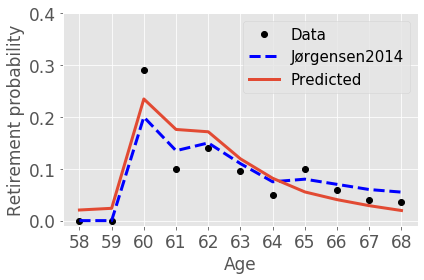

In [11]:
figs.MyPlot(model_fit(1,Single,mom_data,mom_pred,shape),
            ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/ThomasSingleMen.png')

# Singles - Estimate on own data

In [53]:
shape = (11,8)
moments = pd.read_excel('SASdata/single_moments.xlsx')
mom_data = moments['Moments'].to_numpy()
mm = mom_data.reshape(shape)
mom_se = moments['SE'].to_numpy()
weight = SMD.weight_matrix_single(mom_se,shape,factor=[1/10,1/10,1,1,1,1,1,1,1,1,1])
ww = np.diag(weight).reshape(shape)

### Weight matrix

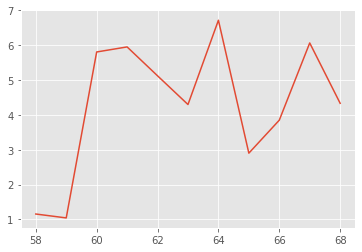

In [54]:
plt.plot(np.arange(58,69),np.mean(ww,axis=1))

### Moments

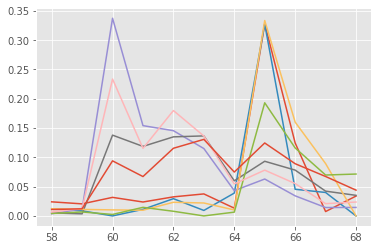

In [55]:
plt.plot(np.arange(58,69),mm)
plt.show()

### Set up estimation

In [56]:
Single = RetirementClass(simN=int(1e5), simT=68-57+1)
Single.solve()
Single.simulate()

In [64]:
# function to generate moments
def mom_fun(Single):
    return SMD.MomFunSingle(Single)

In [65]:
add_str = '_est'
est_par = ("alpha_0_male", "alpha_0_female", "sigma_eta")
est_par_tex = (r'$\alpha_0^m$', r'$\alpha_0^f$', r'$\alpha_1$', r'$\sigma$')
fixed_par = ('R', 'rho', 'beta', 'gamma', 
             'priv_pension_male', 'priv_pension_female', 'g_adjust', 'pi_adjust_m', 'pi_adjust_f')
fixed_par_tex = (r'$R$', r'$\rho$', r'$\beta$', r'$\gamma$', 
                 r'$PPW^m$', r'$PPW^f$', r'$g$', r'$\pi_m$', r'$\pi_f$')

# Setup estimation
smd = SMD.SimulatedMinimumDistance(Single,mom_data,mom_fun)
smd.est_par = est_par

### Estimate

In [66]:
theta0 = SMD.start(10,bounds=[(0.0,1.0), (0.0,1.0), (-1.0,1.0), (0.1,0.8)])

In [67]:
smd.MultiStart(theta0,weight)
theta = smd.est

1 estimation:
success: True | feval: 135 | time: 2.2 min | obj: 0.8863588348103106
start par: [0.179, 0.91, -0.772, 0.427]
par:       [ 0.36456728  0.6131922  -0.1804749   0.83470543]

2 estimation:
success: True | feval: 108 | time: 1.6 min | obj: 0.834254832445058
start par: [0.573, 0.318, -0.057, 0.406]
par:       [ 0.27372597  0.52716836 -0.04544247  0.5017441 ]

3 estimation:
success: True | feval: 329 | time: 4.9 min | obj: 1.0886314036678875
start par: [0.894, 0.585, 0.992, 0.265]
par:       [ 0.51582632  0.53661645 -0.18470545  0.78459999]

4 estimation:
success: True | feval: 182 | time: 2.6 min | obj: 0.8398757430413785
start par: [0.536, 0.469, -0.763, 0.228]
par:       [ 0.31204511  0.54779212 -0.081091    0.6727234 ]

5 estimation:
success: True | feval: 216 | time: 3.3 min | obj: 1.0953048721202663
start par: [0.017, 0.285, 0.575, 0.211]
par:       [-0.03714129  0.44359576  0.04648055  1.48489542]

6 estimation:
success: True | feval: 110 | time: 1.6 min | obj: 0.88087801

In [68]:
Nobs = 500
smd.std_error(theta,weight,Nobs=Nobs,Nsim=Single.par.simN/Nobs)
std_error = smd.std
smd.obj_fun(theta,weight) # set theta as parameters
print('Parameters:', np.round(theta,3))
print('Std error :', np.round(std_error,4))
SMD.save_est(est_par,theta,name='Single') # save parameters

Parameters: [ 0.263  0.506 -0.045  0.565]
Std error : [0.0019 0.0019 0.0039 0.0009]


### Model fit

In [ ]:
def model_fit(ma,Single):
    data = pd.read_excel('SASdata/single_moments_total.xlsx')
    data = data['Moments'].to_numpy()
    mom_data = {'y': [data.reshape((2,11))[ma]], 'x': np.arange(58,69), 'label': ['Data'], 'color': 'k',
                'linestyle': ['None'], 'marker': 'o'}
    pred = figs.retirement_probs(Single,MA=[ma])
    pred['legendsize'] = 15
    return [mom_data, pred]

In [38]:
figs.MyPlot(model_fit([0]),ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/SingleWomen.png')

In [39]:
figs.MyPlot(model_fit([1]),ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/SingleMen.png')

### Sensitivity to first step calibrated parameters

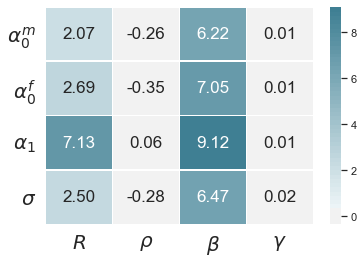

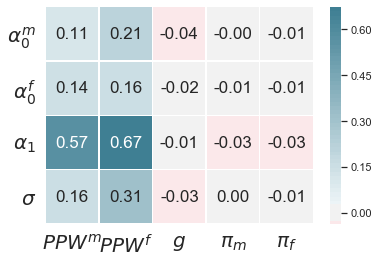

In [230]:
smd.recompute=True
smd.sensitivity(theta,weight,fixed_par)
figs.sens_fig_tab(smd.sens2[:,:4],smd.sens2e[:,:4],theta,est_par_tex,fixed_par_tex[:4]).savefig('figs/Sens/SinglePref.png')
figs.sens_fig_tab(smd.sens2[:,4:],smd.sens2e[:,4:],theta,est_par_tex,fixed_par_tex[4:]).savefig('figs/Sens/SingleCali.png')

# Couples - calibrate to data in Jørgensen 2014

In [12]:
shape = (2,11)
moments = pd.read_excel('SASdata/Thomas/couple_moments.xlsx')
mom_data = moments['Mom_data'].to_numpy()
mom_pred = moments['Mom_est'].to_numpy()
weight = np.eye(mom_data.size) # identity matrix

### Set up estimation

In [ ]:
spar = {'alpha_1': 0.053}
cpar = {'alpha_1': 0.053, 'phi_0_male': 1.187, 'phi_0_female': 1.671, 'phi_1': -0.621}
Couple = RetirementClass(couple=True, Thomas=True, simN=int(1e5), simT=68-53+1, single_kwargs=spar, **cpar)
Couple.solve()
Couple.simulate()

In [ ]:
# function to generate moments
def mom_fun(Couple):
    return SMD.MomFunCoupleThomas(Couple)

In [ ]:
est_par = ("alpha_0_male", "alpha_0_female", "sigma_eta")
smd = SMD.SimulatedMinimumDistance(Couple,mom_data,mom_fun)
smd.est_par = est_par

### Estimate

In [ ]:
theta0 = SMD.start(5,bounds=[(0.0,1.0), (0.0,1.0), (0.1,1.0)])

In [ ]:
smd.MultiStart(theta0,weight)
theta = smd.est

In [ ]:
Nobs = 73844 # equal to number of men-households (which is lower than women)
smd.std_error(theta,weight,Nobs=Nobs,Nsim=5e5/Nobs) # Nsim was set to 5e5 in MultiStart 
std_error = smd.std
smd.obj_fun(theta,weight) # set theta as parameters
print('Parameters:', np.round(theta,3))
print('Std error :', np.round(std_error,4))
est_par = list(est_par)
est_par.append("alpha_1")
est_par.append("phi_0_male")
est_par.append("phi_0_female")
est_par.append("phi_1")
theta = list(theta)
theta.append(Couple.par.alpha_1)
theta.append(Couple.par.phi_0_male)
theta.append(Couple.par.phi_0_female)
theta.append(Couple.par.phi_1)
SMD.save_est(est_par,theta,name='CoupleThomas') # save parameters

### Model fit

In [ ]:
def model_fit(ma,Couple,mom_data,mom_pred,shape):
    mom_data = {'y': [mom_data.reshape(shape)[ma]], 'x': np.arange(58,69), 'label': ['Data'], 'color': 'k',
                'linestyle': ['None'], 'marker': 'o'}
    mom_pred = {'y': [mom_pred.reshape(shape)[ma]], 'x': np.arange(58,69), 'label': ['Jørgensen2014'], 'color': 'b',
                'linestyle': ['--']}    
    pred = figs.retirement_probs_c(Couple,ma=ma)
    pred['legendsize'] = 15
    return [mom_data, mom_pred, pred]

In [ ]:
figs.MyPlot(model_fit(0,Couple,mom_data,mom_pred,shape),
            ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/ThomasCoupleWomen.png')

In [ ]:
figs.MyPlot(model_fit(1,Couple,mom_data,mom_pred,shape),
            ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/ThomasCoupleMen.png')

### Now re-estimate with phi=0

In [ ]:
Couple.par.phi_0_male = 0.0
Couple.par.phi_0_female = 0.0
Couple.par.phi_1 = 0.0

In [ ]:
est_par = ("alpha_0_male", "alpha_0_female", "sigma_eta")
smd = SMD.SimulatedMinimumDistance(Couple,mom_data,mom_fun)
smd.est_par = est_par
theta0 = SMD.start(5,bounds=[(0.0,1.0), (0.0,1.0), (0.1,1.0)])

In [ ]:
smd.MultiStart(theta0,weight)
theta = smd.est

In [ ]:
Nobs = 73844 # equal to number of men-households (which is lower than women)
smd.std_error(theta,weight,Nobs=Nobs,Nsim=5e5/Nobs) # Nsim was set to 5e5 in MultiStart 
std_error = smd.std
smd.obj_fun(theta,weight) # set theta as parameters
print('Parameters:', np.round(theta,3))
print('Std error :', np.round(std_error,4))
est_par = list(est_par)
est_par.append("alpha_1")
est_par.append("phi_0_male")
est_par.append("phi_0_female")
est_par.append("phi_1")
theta = list(theta)
theta.append(Couple.par.alpha_1)
theta.append(Couple.par.phi_0_male)
theta.append(Couple.par.phi_0_female)
theta.append(Couple.par.phi_1)
SMD.save_est(est_par,theta,name='RestCoupleThomas') # save parameters

In [ ]:
figs.MyPlot(model_fit(0,Couple,mom_data,mom_pred,shape),
            ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/ThomasRestCoupleWomen.png')

In [ ]:
figs.MyPlot(model_fit(1,Couple,mom_data,mom_pred,shape),
            ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/ThomasRestCoupleMen.png')

# Couples - Estimate on own data

In [4]:
shape = (2,11,9+16)
moments = pd.read_excel('SASdata/couple_moments.xlsx',skip_blank_lines=False)
mom_data = np.concatenate((moments['Moments_H'].to_numpy(),moments['Moments_W'].to_numpy()))
mm = mom_data.reshape(shape)
idx_nan = np.nonzero(np.isnan(mom_data))[0]
mom_data[idx_nan] = 0
mom_se = np.concatenate((moments['SE_H'].to_numpy(),moments['SE_W'].to_numpy()))
weight = SMD.weight_matrix_couple(mom_se,shape,factor=[1,1,1,1,1,1,1,1,1,1,1]) # factor rescales the time periods
ww = np.diag(weight).reshape(shape)

In [2]:
#shape = (2,11,9+4)
#moments = pd.read_excel('SASdata/couple_moments_hs_elig.xlsx',skip_blank_lines=False)
#mom_data = np.concatenate((moments['Moments_H'].to_numpy(),moments['Moments_W'].to_numpy()))
#mm = mom_data.reshape(shape)
#idx_nan = np.nonzero(np.isnan(mom_data))[0]
#mom_data[idx_nan] = 0
#mom_se = np.concatenate((moments['SE_H'].to_numpy(),moments['SE_W'].to_numpy()))
#weight = SMD.weight_matrix_couple(mom_se,shape,factor=[1/4,1/3,1,1,1,1,1,1,1,1,1]) # factor rescales the time periods
#ww = np.diag(weight).reshape(shape)

### Weight matrix

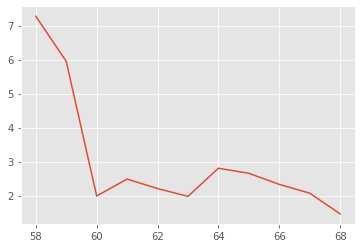

In [5]:
plt.plot(np.arange(58,69),np.mean(ww,axis=(0,2)))

### Moments - Women

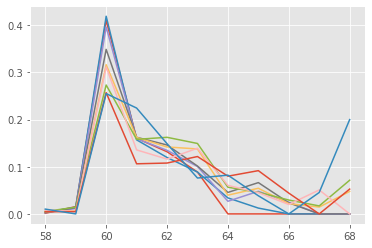

In [6]:
plt.plot(np.arange(58,69), mm[1,:,:9])
plt.show()

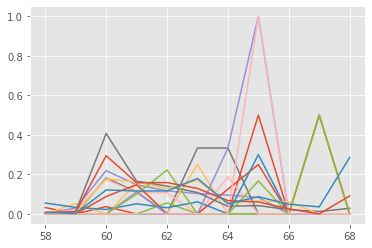

In [7]:
plt.plot(np.arange(58,69), mm[1,:,9:])
plt.show()

Moments - Men

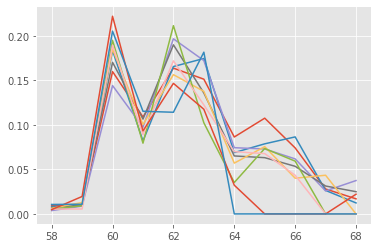

In [8]:
plt.plot(np.arange(58,69), mm[0,:,:9])
plt.show()

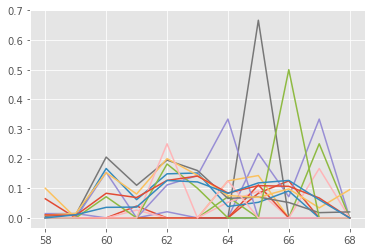

In [9]:
plt.plot(np.arange(58,69), mm[0,:,9:])
plt.show()

### Set up estimation

In [ ]:
Couple = RetirementClass(couple=True, simN=int(1e5), simT=68-53+1, cov=0)
Couple.solve()
Couple.simulate()

In [ ]:
# function to generate moments
def mom_fun(Couple):
    return SMD.MomFunCouple(Couple,idx_nan)
    #return SMD.MomFunCouple_hs_elig(Couple,idx_nan)

In [ ]:
add_str = '_est'
est_par = ("alpha_0_male", "alpha_0_female", "alpha_1", "sigma_eta", "phi_0_male", "phi_1")
est_par_tex = (r'$\alpha_0^m$', r'$\alpha_0^f$', r'$\alpha_1$', r'$\sigma$', r'$\phi_0$', r'$\phi_1$')
fixed_par = ('R', 'rho', 'beta', 'gamma', 'v',
             'priv_pension_male', 'priv_pension_female', 'g_adjust', 'pi_adjust_m', 'pi_adjust_f')
fixed_par_tex = (r'$R$', r'$\rho$', r'$\beta$', r'$\gamma$', r'$v$', 
                 r'$PPW^m$', r'$PPW^f$', r'$g$', r'$\pi_m$', r'$\pi_f$')

# Setup estimation
smd = SMD.SimulatedMinimumDistance(Couple,mom_data,mom_fun)
smd.est_par = est_par

### Estimate

In [ ]:
theta0 = SMD.start(10,bounds=[(0.0,1.0),(0.0,1.0),(-1.0,1.0),(0.2,0.8),(0.0,1.0),(-1.0,1.0)])

With all moments across hs and elig

In [ ]:
smd.MultiStart(theta0,weight)
theta = smd.est

In [ ]:
Nobs = 100
smd.std_error(theta,weight,Nobs=Nobs,Nsim=Couple.par.simN/Nobs)
std_error = smd.std
smd.obj_fun(theta,weight) # set theta as parameters
print('Parameters:', np.round(theta,3))
print('Std error :', np.round(std_error,4))
SMD.save_est(est_par,theta,name='Couple') # save parameters

In [ ]:
def model_fit(Couple,ma):
    moments = pd.read_excel('SASdata/couple_moments_total.xlsx')
    mom = moments['Moments'].to_numpy().reshape(2,11)
    data = {'y': [mom[ma]], 'x': np.arange(58,69), 'label': ['Data'], 'color': 'k',
            'linestyle': ['None'], 'marker': 'o'}    
    pred = figs.retirement_probs_c(Couple,ma=ma)
    return [data,pred]

In [ ]:
np.mean(figs.RetAge_C(Couple,ma=0))

In [ ]:
np.mean(figs.RetAge_C(Couple,ma=1))

In [ ]:
figs.MyPlot(model_fit(Couple,0),ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/CoupleWomen.png')

In [ ]:
figs.MyPlot(model_fit(Couple,1),ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/CoupleMen.png')

With moments for hs and elig separately

In [12]:
smd.MultiStart(theta0,weight)
theta = smd.est

1 estimation:
success: True | feval: 250 | time: 44.5 min | obj: 2.019647055890923
start par: [0.888, 0.177, 0.96, 0.73, 0.551, 0.633]
par:       [ 0.34486072  0.26388241 -0.29785464  0.89365759  1.18801869  0.53412039]

2 estimation:
success: True | feval: 366 | time: 62.8 min | obj: 2.004012481323837
start par: [0.018, 0.54, -0.567, 0.434, 0.609, 0.93]
par:       [ 0.02513322  0.14277416 -0.10331484  0.77806843  6.11510172 -5.85077245]

3 estimation:
success: True | feval: 278 | time: 49.3 min | obj: 1.8459189271531073
start par: [0.215, 0.631, -0.336, 0.67, 0.006, -0.587]
par:       [ 0.78989092  0.30355572 -0.37230901  0.68057954  0.00623897  0.06052501]

4 estimation:
success: True | feval: 251 | time: 45.6 min | obj: 1.9709075059425873
start par: [0.613, 0.729, 0.122, 0.601, 0.923, -0.159]
par:       [ 0.87503454  0.16559809  0.10386799  0.58150397 -0.13133654 -0.35828139]

5 estimation:
success: True | feval: 270 | time: 48.8 min | obj: 2.003050954422142
start par: [0.748, 0.113

In [14]:
theta

array([ 0.8097936 ,  0.27982001, -0.39997974,  0.68578428,  0.05761685,
       -0.00919087])

In [15]:
smd.obj_fun(theta,weight)

1.848257339210825

In [13]:
Nobs = 100
smd.std_error(theta,weight,Nobs=Nobs,Nsim=Couple.par.simN/Nobs)
std_error = smd.std
smd.obj_fun(theta,weight) # set theta as parameters
print('Parameters:', np.round(theta,3))
print('Std error :', np.round(std_error,4))
SMD.save_est(est_par,theta,name='Couple') # save parameters

Parameters: [ 0.81   0.28  -0.4    0.686  0.058 -0.009]
Std error : [0.0003 0.0002 0.0004 0.0003 0.0006 0.0152]


TypeError: save_est() got an unexpected keyword argument 'couple'

In [16]:
def model_fit(Couple,ma):
    moments = pd.read_excel('SASdata/couple_moments_total.xlsx')
    mom = moments['Moments'].to_numpy().reshape(2,11)
    data = {'y': [mom[ma]], 'x': np.arange(58,69), 'label': ['Data'], 'color': 'k',
            'linestyle': ['None'], 'marker': 'o'}    
    pred = figs.retirement_probs_c(Couple,ma=ma)
    return [data,pred]

In [20]:
np.mean(figs.RetAge_C(Couple,ma=0))

61.92561667959754

In [21]:
np.mean(figs.RetAge_C(Couple,ma=1))

62.85268975588876

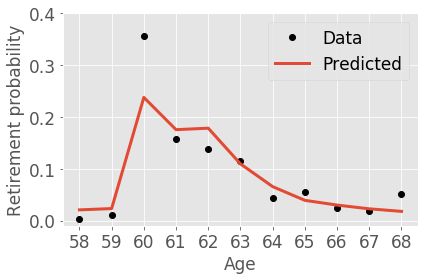

In [17]:
figs.MyPlot(model_fit(Couple,0),ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/CoupleWomen.png')

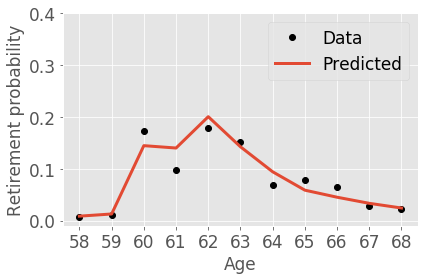

In [18]:
figs.MyPlot(model_fit(Couple,1),ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/CoupleMen.png')

### Sensitivity to first step calibrated parameters

In [ ]:
smd.recompute=True
smd.sensitivity(theta,weight,fixed_par)
figs.sens_fig_tab(smd.sens2[:,:5],smd.sens2e[:,:5],theta,est_par_tex,fixed_par_tex[:5]).savefig('figs/Sens/CouplePref.png')
figs.sens_fig_tab(smd.sens2[:,5:],smd.sens2e[:,5:],theta,est_par_tex,fixed_par_tex[5:]).savefig('figs/Sens/CoupleCali.png')

### Estimate (phi=0)

In [ ]:
Couple.par.phi_0_male = 0
Couple.par.phi_0_female = 0
Couple.par.phi_1 = 0
smd = SMD.SimulatedMinimumDistance(Couple,mom_data,mom_fun)
smd.est_par = est_par[0:4]

In [ ]:
theta0 = SMD.start(10,bounds=[(0.0,1.0),(0.0,1.0),(-1.0,1.0),(0.2,0.8)])

In [ ]:
smd.MultiStart(theta0,weight)
theta = smd.est

In [ ]:
Nobs = 100
smd.std_error(theta,weight,Nobs=Nobs,Nsim=Couple.par.simN/Nobs)
std_error = smd.std
print('Parameters:', np.round(theta,3))
print('Std error :', np.round(std_error,4))
SMD.save_est(est_par,theta,name='RestCouple',couple=True) # save parameters

In [ ]:
figs.MyPlot(model_fit(Couple,0),ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/RestCoupleWomen.png')

In [ ]:
figs.MyPlot(model_fit(Couple,1),ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/RestCoupleMen.png')